In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime # 用于datetime对象操作
import backtrader as bt # 引入backtrader框架
import pandas as pd
import tushare as ts
import copy
import numpy as np
import re

In [2]:
#股票池
l=[
'603566.SH',
'603466.SH',
'601068.SH',
'603628.SH',
'603725.SH',
'603918.SH',
'600466.SH',
'600075.SH',
'603331.SH',
'603777.SH'
]
stk=pd.DataFrame(l,columns=['code'])
'''
stk=pd.read_csv("./test-raw-1.csv")

df_code=stk['sec_code'].str[0:9]
d=[]
for code in df_code:
    df_code=re.sub('_',r'.',code)
    d.append(df_code)
    df_code=pd.DataFrame({'code':d})
stk=pd.concat([stk,df_code],axis=1)
stk['news_time']=stk['news_time'].str[0:10]
stk=stk.head(1)

code = stk['code'][stk.index[0]]#从股票池取出一只标的
    #回测期间
'''
global start,end,d1,d2
start=datetime.datetime(2019,6,30)#设置开始
end=datetime.datetime(2020,6,30)#设置结束
d1=start.strftime('%Y%m%d')
d2=end.strftime('%Y%m%d')

In [3]:
class percent(bt.Sizer):
    params = (
    ('percents', 10),
    ('retint', False),  # 返回整数
)
 
    def __init__(self):
        pass
 
    def _getsizing(self, comminfo, cash, data, isbuy):
        position = self.broker.getposition(data)
        if not position:
            size = cash / data.close[0] * (self.params.percents / 100)
        else:
            size = position.size
 
        if self.p.retint:
            size = int(size)
 
        return size

In [4]:
class SmaStrategy(bt.Strategy):
    # 可配置策略参数
    params = dict(
        period = 30,    # 均线周期
        stake = 100,            # 单笔交易股票数目
    )
    def __init__(self):
        self.inds = dict()
        for i, d in enumerate(self.datas):
            self.inds[d] = bt.ind.SMA(d.close, period=self.p.period)

    def next(self):
        for i, d in enumerate(self.datas):
            pos = self.getposition(d)
            if not len(pos):                               
                if d.close[0] > self.inds[d][0]:             # 达到买入条件
                    self.buy(data = d, size = self.p.stake)  
            elif d.close[0] < self.inds[d][0]:               # 达到卖出条件
                self.sell(data = d)                       

In [11]:
cerebro = bt.Cerebro()  # 初始化cerebro

################### 股票代码和回测时间 #####################

def get_data(code,d1,d2):#此处时间应与下面回测期间一致
    pro = ts.pro_api()
    df = ts.pro_bar(ts_code=code, adj='qfq', start_date=d1, end_date=d2)
    df.index=pd.to_datetime(df.trade_date)
    df.sort_index(ascending=True,inplace=True)
    df=df.rename(columns={'vol':'volume'})
    df['openinterest']=0
    df=df[['open','high','low','close','volume','openinterest']]
    return df
###########################################

# 读入股票代码
for i in range(len(stk['code'])):
    code = stk['code'][stk.index[i]]#从股票池取出一只标的
    #回测期间已全局定义
    # 获取数据
    dataframe=get_data(code,d1,d2)
    # 加载数据
    data = bt.feeds.PandasData(dataname=dataframe,fromdate=start,todate=end)
    # 在Cerebro中添加股票数据
    cerebro.adddata(data, name = code)
    
##################### 代码和时间加载完毕 ########################

In [12]:
################## cerebro整体设置 #####################
# 设置启动资金
startcash=100000.0
cerebro.broker.setcash(startcash)
# 设置交易手续费为 0.05%
cerebro.broker.setcommission(commission=0.0005)
#设置订单份额
cerebro.addsizer(percent)
# 将交易策略加载到回测系统中
cerebro.addstrategy(SmaStrategy)

import backtrader.analyzers as btay#添加分析函数
# 添加分析对象
cerebro.addanalyzer(btay.SharpeRatio,_name="sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='DW')

#打印
print(f'回测期间：{d1}:{d2}\n初始资金: {startcash}')
# 运行回测
results = cerebro.run()
# 打印最后结果
portvalue = cerebro.broker.getvalue()
pnl = portvalue - startcash
#打印结果
print(f'总资金: {round(portvalue,2)}')
print(f'净收益: {round(pnl,2)}')
print("夏普比例:", results[0].analyzers.sharpe.get_analysis())
print("回撤",results[0].analyzers.DW.get_analysis())

回测期间：20190630:20200630
初始资金: 100000.0
总资金: 99751.8
净收益: -248.2
夏普比例: OrderedDict([('sharperatio', -4.174566295064498)])
回撤 AutoOrderedDict([('len', 185), ('drawdown', 1.5776215759064887), ('moneydown', 1598.9310499999556), ('max', AutoOrderedDict([('len', 185), ('drawdown', 2.8404556492517434), ('moneydown', 2878.8226549999963)]))])


<IPython.core.display.Javascript object>


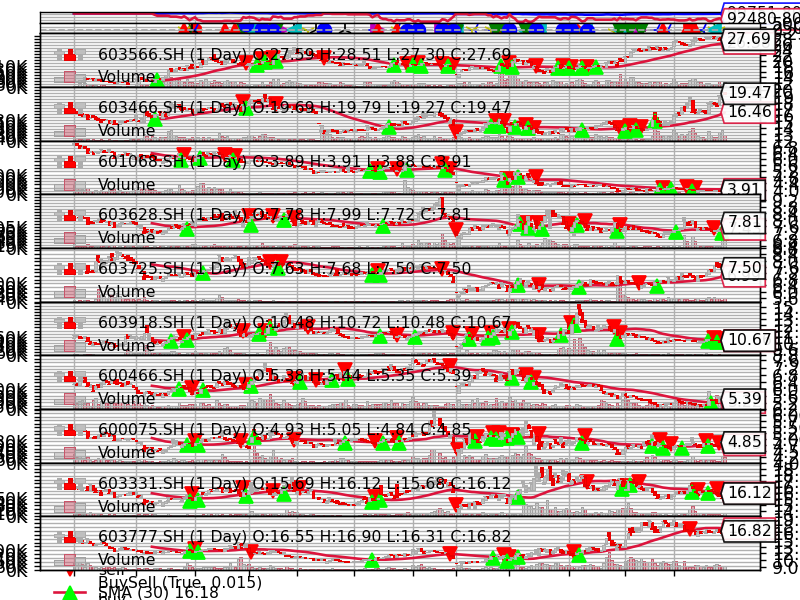

[[<Figure size 640x480 with 22 Axes>]]

In [13]:
cerebro.plot(style = "candlestick")  # 绘图